# Imports

In [62]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow
from keras.preprocessing.image import load_img,img_to_array
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from collections import Counter
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg

# Functions 

In [2]:
def train_dev_test_split(images, labels):
    #train->0.7, dev->0.15, test->0.15
    frac_train=0.7
    frac_test=0.15
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=frac_test, random_state=78)
    frac_dev=0.15/(frac_train+frac_test)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=frac_dev, random_state=78)
    print("Train Set:",X_train.shape, "| Dev Set:",X_dev.shape, "| Test Set:",X_test.shape )
    return(X_train, X_test, X_dev, y_train, y_test, y_dev)

In [67]:
#convert raw rgb image to normalized in [0,1] one-hot vectors
def load_reshape_img(img,grayscale):
    x = img_to_array(img)/255.
    if grayscale==True:
        x = rgb2gray(x)   
    x = x.reshape((1,)+x.shape)
    x = x.flatten()
    return x

In [68]:
def rgb2gray(rgb): #https://pillow.readthedocs.io/en/3.2.x/reference/Image.html#PIL.Image.Image.convert
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [69]:
#convert the dataset with features the image names to dataset with features theflattened one hot encoding vectors of pixels
def create_flattened_dataset(dataset,size,grayscale):
    dataset_copy=dataset.copy()
    for i in dataset:
        img_name=images_folder + i
        img = load_img(img_name, target_size=size)
        img_vector=load_reshape_img(img,grayscale)
        dataset_copy.loc[int(img_name.split('/')[-1].split('.')[0])] = img_vector
        #print("Gender: ",dataset.loc[int(img_name.split('/')[-1].split('.')[0])]['gender'])

    #convert Series of numpy arrays to 2D np
    #images_np=np.array(images.values.tolist())
    print("Dataset type before stacking rows:",type(dataset_copy), "with shape:",dataset_copy.shape)
    dataset_np=np.stack(dataset_copy)
    print("Dataset type after stacking rows:",type(dataset_np), "with shape:",dataset_np.shape)
 
    #convert 2D np to pd
    dataset_pd = pd.DataFrame(dataset_np)
    print("Convert 2D np array to pd again...")
    #print(dataset_pd.head())
    return(dataset_pd)

In [99]:
#check for NaN values in one-hot encodings ,e.g. missing pixels
def check_NaN_values(features,_labels):
    _labels=np.array(_labels)
    NaNvaluesData=np.isnan(_labels).sum().sum()
    if NaNvaluesData>0 :
            where_is_NaN = np.isnan(_labels)
            print("NaN value in labels index: ",where_is_NaN)
    else:
        print("No NaN values in Labels.")


    features=np.array(features)
    NaNvaluesData=np.isnan(features).sum().sum()
    if NaNvaluesData>0 :
        where_is_NaN = np.isnan(features)
        print("Number of NaN values in augmented image: ",where_is_NaN)
    else:
        print("No NaN values in Reshaped Images.")
        
    return

In [6]:
def plot_splitted_dataset_distribution(y_train, y_test, y_dev):
    sample_list_names=["Train","Dev","Test"]
    sample_list=[y_train,y_dev,y_test]

    fig = plt.figure(figsize=(15,10))
    #fig.subplots_adjust(hspace=1, wspace=1)
    
    for i in range(1, 4):
        ax = fig.add_subplot(2,3, i)
        height = Counter(sample_list[i-1])
        bars=('Female','Male')
        pop = plt.bar(bars, height.values(),color=[ 'r','k'])
        plt.xlabel('Gender')
        plt.title('Gender Distribution for '+ sample_list_names[i-1])
    return

In [33]:
#function for SVM classifier with parameters of kernel, gamma and C
def SVM_Classifier(kernel, gamma, C, X_train, y_train, X_dev):
    clf = svm.SVC(kernel=kernel, C=C, gamma=gamma)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_dev)
    print(classification_report(y_dev, preds))
    print("\nAccuracy Score: ","{:.0%}".format(accuracy_score(y_dev, preds)))
    conf_matrix = confusion_matrix(y_dev, preds)
    labels=['F','M']
    sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels,cmap= "BuPu")
    plt.show() 
    return(svm, preds)

In [8]:
def plot_decision_regions(X,y,classifier,resolution=0.02):
    
    # Initialise the marker types and colors
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    color_Map = ListedColormap(colors[:len(np.unique(y))]) #we take the color mapping correspoding to the 
                                                            #amount of classes in the target data
    
    # Parameters for the graph and decision surface
    x1_min = X[:,0].min() - 1
    x1_max = X[:,0].max() + 1
    x2_min = X[:,1].min() - 1
    x2_max = X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                           np.arange(x2_min,x2_max,resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.figure(figsize=(10,10))
    plt.contour(xx1,xx2,Z,alpha=0.7,cmap = color_Map)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    # Plot samples
    X_test, Y_test = X, y
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0], y = X[y == cl, 1],
                    alpha = 0.8, c = color_Map(idx),
                    marker = markers[idx], label = cl
                   )
        
            
#     # Plot samples
#     X_test, Y_test = X, y
    
#     plt.scatter(x = X[y == 0, 0], y = X[y == 0, 1],
#                     alpha = 0.8, c = color_Map(0),
#                     marker = markers[0],label='Class 0')
                
#     plt.scatter(x = X[y == 1, 0], y = X[y == 1, 1],
#                     alpha = 0.8, c = color_Map(1),
#                     marker = markers[1],label='Class 1')
# #     plt.scatter(x = X[y == 2, 0], y = X[y == 2, 1],
# #                     alpha = 0.8, c = color_Map(2),
# #                     marker = markers[1],label='Class 2')


# Read Data

In [83]:
dataset = pd.read_csv('../Datasets/celeba/labels.csv', sep = '\t', usecols = [1,2])
print("Dataset Size: ",dataset.shape)
dataset.head()

Dataset Size:  (5000, 2)


,img_name,gender
0,0.jpg,-1
1,1.jpg,-1
2,2.jpg,1
3,3.jpg,-1
4,4.jpg,-1


In [100]:
images = dataset.iloc[:,0]
labels = dataset.iloc[:,1]

**Example of a picture in CelebA dataset:**

Gender:  -1
(255, 255, 3)
(1, 255, 255, 3)
(195075,)
Total pixels: 65025


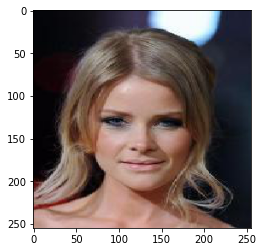

In [85]:
# set variables 
images_folder = '../Datasets/celeba/img/'
EXAMPLE_PIC = images_folder + '9.jpg'

# plot picture and attributes
#img = load_img(EXAMPLE_PIC)
#target_size=(218, 178) => target_size=(255,255): equalize the dimensions for simplicity
img = load_img(EXAMPLE_PIC,target_size=(255,255))
plt.imshow(img)
print("Gender: ",dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['gender'])

x_arr = img_to_array(img)/255.
print(x_arr.shape)
x = x_arr.reshape((1,)+x_arr.shape)
print(x.shape)
x = x.flatten()
print(x.shape)

#getdata() returns the contents of this image as a sequence object containing pixel values
pix_val = list(img.getdata())
print("Total pixels:",len(pix_val))

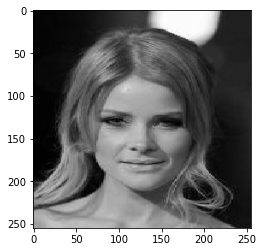

(255, 255)
(1, 255, 255)
(65025,)
Total pixels: 65025


In [86]:
gray = rgb2gray(x_arr)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()
print(gray.shape)
x = gray.reshape((1,)+gray.shape)
print(x.shape)
x = x.flatten()
print(x.shape)

#getdata() returns the contents of this image as a sequence object containing pixel values
pix_val = list(img.getdata())
print("Total pixels:",len(pix_val))

In [12]:
x = img_to_array(img)/255.
print(x.shape)
x = x.reshape((1,)+x.shape)
x=x.flatten()
x=x.reshape(255,255,3)
print(x.shape)

(255, 255, 3)
(255, 255, 3)


In [87]:
females = dataset[dataset['gender']==-1].count()[0]
males = dataset[dataset['gender']==1].count()[0]
print('Females: {}  | Males: {}'.format(females,males))
print("Balanced Dataset!!")

Females: 2500  | Males: 2500
Balanced Dataset!!


## Convert images dataframe to reshaped array images dataframe

In [101]:
size=(100,100)
grayscale=False
reshaped_images=create_flattened_dataset(images,size,grayscale)

Dataset type before stacking rows: <class 'pandas.core.series.Series'> with shape: (5000,)
Dataset type after stacking rows: <class 'numpy.ndarray'> with shape: (5000, 30000)
Convert 2D np array to pd again...


**Check for NaN values**

In [102]:
check_NaN_values(reshaped_images,labels)

No NaN values in Labels.
No NaN values in Reshaped Images.


**Train, Dev, Test split** 

In [103]:
X_train, X_test, X_dev, y_train, y_test, y_dev=train_dev_test_split(reshaped_images, labels)

Train Set: (3500, 30000) | Dev Set: (750, 30000) | Test Set: (750, 30000)


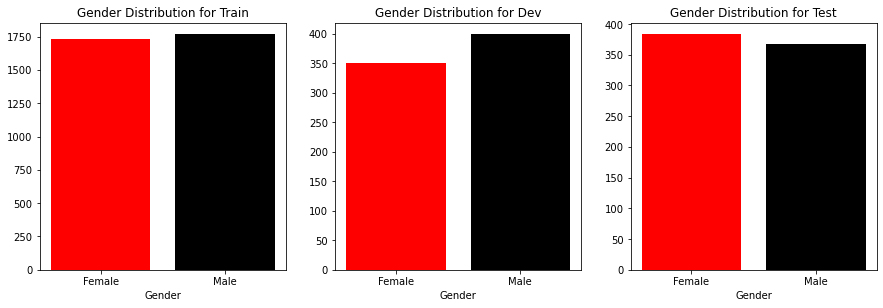

In [91]:
plot_splitted_dataset_distribution(y_train, y_test, y_dev)

# Baseline Classification Estimator

## 1. kNN Classifier

In [92]:
#default neighbors=5
clf = neighbors.KNeighborsClassifier()
clf.fit(X_train,y_train)
preds = clf.predict(X_dev)
print(classification_report(y_dev, preds))
print("\nAccuracy Score: ","{:.0%}".format(accuracy_score(y_dev, preds)))

              precision    recall  f1-score   support

          -1       0.66      0.76      0.71       351
           1       0.76      0.65      0.70       399

    accuracy                           0.70       750
   macro avg       0.71      0.71      0.70       750
weighted avg       0.71      0.70      0.70       750


Accuracy Score:  70%


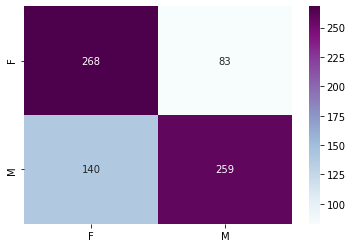

In [93]:
conf_matrix = confusion_matrix(y_dev, preds)
labels=['F','M']
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels, cmap= "BuPu")
plt.show()

## 2. Linear SVM

The most basic way to use a SVM is with a linear kernel, which means the decision boundary is a straight line (or hyperplane in higher dimensions like here).

              precision    recall  f1-score   support

          -1       0.87      0.90      0.88       351
           1       0.91      0.88      0.89       399

    accuracy                           0.89       750
   macro avg       0.89      0.89      0.89       750
weighted avg       0.89      0.89      0.89       750


Accuracy Score:  89%


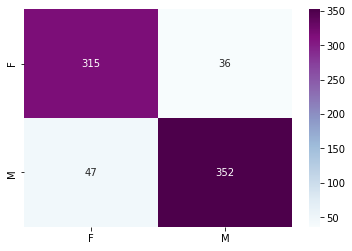

In [94]:
kernel='linear'
gamma='auto'
C=1.0 #default
clf_svm_linear, preds_svm_linear = SVM_Classifier(kernel, gamma, C, X_train, y_train, X_dev)

## 3. RBF SVM
The RBF kernel SVM decision region is actually also a linear decision region. What RBF kernel SVM actually does is to create non-linear combinations of your features to uplift your samples onto a higher-dimensional feature space where you can use a linear decision boundary to separate your classes:
https://www.kdnuggets.com/2016/06/select-support-vector-machine-kernels.html

* **Gamma**:
gamma is a parameter of the RBF kernel and can be thought of as the ‘spread’ of the kernel and therefore the decision region. When gamma is low, the ‘curve’ of the decision boundary is very low and thus the decision region is very broad. When gamma is high, the ‘curve’ of the decision boundary is high, which creates islands of decision-boundaries around data points.

* **C**:
C is a parameter of the SVC learner and is the penalty for misclassifying a data point. When C is small, the classifier is okay with misclassified data points (high bias, low variance). When C is large, the classifier is heavily penalized for misclassified data and therefore bends over backwards avoid any misclassified data points (low bias, high variance).

https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/

Since we have high dimensional samples that have not been yet reduced, the cross-validation in grid search method is eschewed because of expensive training and prediction.
Hence wy experience with **some values by hand** just to infer if *rbf kernel* fits well.

In [18]:
best_score = 0
for gamma in [0.001, 0.01, 0.1]:
    for C in [1, 10, 100]:
        # for each combination of parameters, train a SVC
        svm = SVC(kernel='rbf',gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the dev set
        score = svm.score(X_dev, y_dev)
        parameters={'C':C,'gamma':gamma}
        print("Score: {:.2f}".format(score), "for Parameters: {}".format(parameters))
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("\nBest score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Score: 0.85 for Parameters: {'C': 1, 'gamma': 0.001}
Score: 0.85 for Parameters: {'C': 10, 'gamma': 0.001}
Score: 0.85 for Parameters: {'C': 100, 'gamma': 0.001}
Score: 0.47 for Parameters: {'C': 1, 'gamma': 0.01}
Score: 0.48 for Parameters: {'C': 10, 'gamma': 0.01}
Score: 0.48 for Parameters: {'C': 100, 'gamma': 0.01}
Score: 0.47 for Parameters: {'C': 1, 'gamma': 0.1}
Score: 0.47 for Parameters: {'C': 10, 'gamma': 0.1}
Score: 0.47 for Parameters: {'C': 100, 'gamma': 0.1}

Best score: 0.85
Best parameters: {'C': 10, 'gamma': 0.001}


Now, it looks like both linear and RBF kernel SVM would work almost equally well on this dataset. So, why prefer the simpler, linear hypothesis? Think of Occam's Razor in this particular case. Linear SVM is a parametric model, an RBF kernel SVM isn't, and the complexity of the latter grows with the size of the training set. Not only is it more expensive to train an RBF kernel SVM, but you also have to keep the kernel matrix around, and the projection into this "infinite" higher dimensional space where the data becomes linearly separable is more expensive as well during prediction. Furthermore, you have more hyperparameters to tune, so model selection is more expensive as well! And finally, it's much easier to overfit a complex model!
https://www.kdnuggets.com/2016/06/select-support-vector-machine-kernels.html

### Final Classifier

Comparing the accuracies and the time and space used for each classifier we end up in **linear SVM:**

In [52]:
best_score=0.85
data={'kNN (k=5)':[accuracy_score(y_dev, preds)],'Linear SVM':[accuracy_score(y_dev, preds_svm_linear)],
      'SVM rbf {}'.format(best_parameters):[best_score]}
df=pd.DataFrame.from_dict(data,orient='index',columns=['Accuracy Score'])
df.sort_values(by=df.columns[0],ascending=False, inplace=False)

,Accuracy Score
Linear SVM,0.889333
"SVM rbf {'C': 10, 'gamma': 0.001}",0.850000
kNN (k=5),0.702667


## Preproccessing Data

### A. Converting rgb images to gray scale

Hence, initial dimensions are divided by 3. We perform this to simplify our model and check if rgb scale affects the classification process.

**We must keep in mind that each features increases the data set requirement exponentially.**

Dataset type before stacking rows: <class 'pandas.core.series.Series'> with shape: (5000,)
Dataset type after stacking rows: <class 'numpy.ndarray'> with shape: (5000, 10000)
Convert 2D np array to pd again...
Train Set: (3500, 10000) | Dev Set: (750, 10000) | Test Set: (750, 10000)
              precision    recall  f1-score   support

          -1       0.83      0.85      0.84       351
           1       0.86      0.84      0.85       399

    accuracy                           0.85       750
   macro avg       0.84      0.85      0.84       750
weighted avg       0.85      0.85      0.85       750


Accuracy Score:  85%


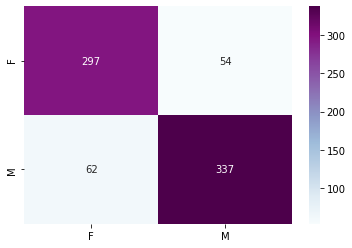

In [105]:
size=(100,100)
grayscale=True
reshaped_images_g=create_flattened_dataset(images,size,grayscale)
X_train_g, X_test_g, X_dev_g, y_train_g, y_test_g, y_dev_g=train_dev_test_split(reshaped_images_g, labels)
kernel='linear'
gamma='auto'
C=1.0 #default
_,_=SVM_Classifier(kernel, gamma, C, X_train_g, y_train_g, X_dev_g)

**No enhancement so we keep up with rgb scale**

### B. Curse of Dimensionality

The curse of dimensionality refers to the phenomena that occur when classifying, organizing, and analyzing high dimensional data that does not occur in low dimensional spaces, specifically the issue of data sparsity and “closeness” of data.

Sparsity of data occurs when moving to higher dimensions. the volume of the space represented grows so quickly that the data cannot keep up and thus becomes sparse.

As the number of features or dimensions grows, the amount of data we need to generalize accurately grows exponentially."
-Charles Isbell, Professor and Senior Associate Dean, School of Interactive Computing, Georgia Tech

Value added by additional dimension is much smaller compared to overhead it adds to the algorithm.

Using too many features compared to fewer samples results in overfitting. The classifier starts learning exceptions that are specific to the training data and do not generalize well when new data is encountered.